# Data Engineering

Once the EDA step was completed, the goal now was to standardize EEG signals so that they can be compared with each other. As both datasets had a different scale of EEG signals.

#### challenges

to work with the Emotion dataset, i used the [MNE package](https://mne.tools/stable/index.html) to read the cnt files in the SEED dataset.

Its a great package, the documentation is good enough to not get lost but elaborate enough to find ones way. I found a way to obtain 28 channels from 68 through the pick channels function.


In [1]:
# loading the libraries
import numpy as np
from zipfile import ZipFile
import matplotlib.pyplot as plt
import os
import pandas as pd
import torch
import random
import argparse
from sklearn import metrics
from tqdm.notebook import tqdm
import gc
import shutil 
import mne
import pickle

In [18]:
labels = ['HandStart', 'FirstDigitTouch', 'BothStartLoadPhase', 'LiftOff',
       'Replace', 'BothReleased']
chanelWant = ['Fp1', 'FC1', 'Fp2', 'P7', 'FC5', 'T7', 'F8', 'P4', 'CP5', 'P3', 'T8', 'Oz', 'FC6', 'O2', 'Cz', 'Fz', 'P8', 'C3', 'CP6', 'CP2', 'CP1', 'Pz', 'O1', 'F3', 'F7', 'C4', 'FC2', 'F4']

with open('chanelID.pickle', 'rb') as f:
    seedchanelWantId = pickle.load(f)


there is some lexical change between the structures of both datasets, like the channel names are case Sensitive in the emotion dataset they are all caps (for instance FP2,CP1) but in the motion they are not (Fp2,Cp1). This meant the need for some string operations to bring them on the same page.

In [ ]:
# chanelWant = ['CP5', 'P7', 'CP1', 'FP2', 'F4', 'P3', 'O1', 'FC5', 'FC1', 'T8', 'PZ', 'O2', 'FC6', 'T7', 'F7', 'F3', 'C4', 'FC2', 'CP6', 'F8', 'OZ', 'FZ', 'FP1', 'C3', 'CZ', 'CP2', 'P8', 'P4']
# print(mne.pick_channels(ch_names=eeg_raw.info['ch_names'],include = chanelWant))
# chWantId = mne.pick_channels(ch_names=eeg_raw.info['ch_names'],include = chanelWant)


## SEED (Shanghai Jiao Tong University)
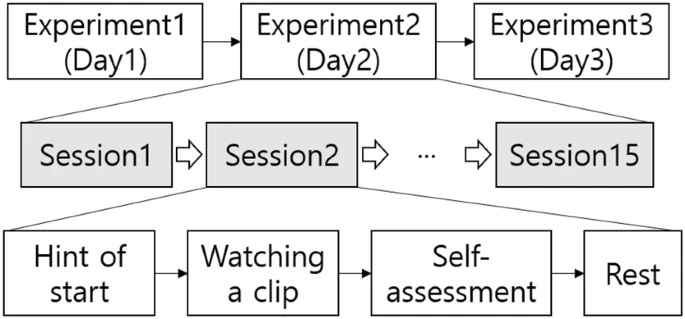

The SEED dataset was collected from 15 subjects (seven males) when they were asked to watch 15 film clips. The duration of each film clip was about 4 min, and each film as easily understood in order to elicit emotion of 15 subjects participating in the experiments effectively. There were 15 trials for each subject and each trial lasted for 305 s consisting of a hint of start for 5 s, a movie clip for 4 min, a self-assessment for 45 s, and a rest for 15 s. EEG data in SEED dataset was collected from 62 electrodes, which includes more information than the DEAP dataset. After collection, EEG data was downsampled to 200 Hz and applied with a bandpass filter from 0 to 75 Hz.

in this dataset, the data are applied with a frequency filter from 4.0 to 45.0 Hz in order to equitably evaluate the proposed network. Negative, positive, and neutral are emotion labels in this dataset that represent the subjects’ emotion states during each experiment. Label value of negative, positive and neutral is −1, 1, and 0, respectively. Thus, labels in the SEED dataset include three categories.


## Emotion Dataset

I constructed the Emotion Dataset from the SEED, by categorising emotions such as Happy, Disgust.etc in Other as they are not part of our research in infering distress through EEGs. 

Hence the labels were as follows:
1. Fear
2. Neutral
3. Other

And as alluded to before in order to meet dimensions that can be compared i selected 28 channels from SEED.

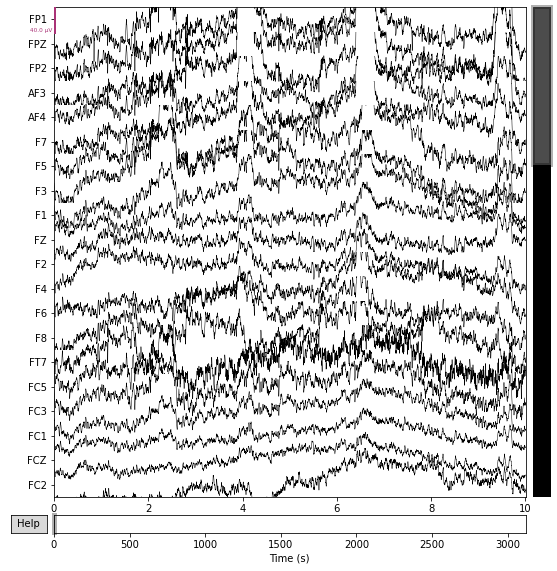

In [37]:
import warnings
warnings.filterwarnings('ignore')
# Loading SEED Data
# the fear trainset
## - Fear is 1 , Neutral is 2, Other is 0

#Session 1:
start_secondOne= [30, 132, 287, 555, 773, 982, 1271, 1628, 1730, 2025, 2227, 2435, 2667, 2932, 3204]
end_secondOne= [102, 228, 524, 742, 920, 1240, 1568, 1697, 1994, 2166, 2401, 2607, 2901, 3172, 3359]

#Session 2:
start_secondTwo= [30, 299, 548, 646, 836, 1000, 1091, 1392, 1657, 1809, 1966, 2186, 2333, 2490, 2741]
end_secondTwo= [267, 488, 614, 773, 967, 1059, 1331, 1622, 1777, 1908, 2153, 2302, 2428, 2709, 2817]

#Session 3:
start_secondThree= [30, 353, 478, 674, 825, 908, 1200, 1346, 1451, 1711, 2055, 2307, 2457, 2726, 2888]
end_secondThree= [321, 418, 643, 764, 877, 1147, 1284, 1418, 1679, 1996, 2275, 2425, 2664, 2857, 3066]

SeedTrainset = []
SeedValidset = []

def extractEEG(data,timestampBegin,timestampEnd,num,signal = 0):
    '''
    takes in the eeg raw data array, and then constructs data chuncks for the 3 respective emotions:
    signal = 0 stands for Other
    signal = 1 stands for Fear
    signal = 2 stands for Neutral
    '''
    
    dum = (data[:,timestampBegin[num]*1000: timestampEnd[num]*1000])
    signalArray = np.zeros((1,dum.shape[1]))
    
    if signal == 1:
        signalArray[0,:] = 1
    elif signal == 2:
        signalArray[1,:] = 1
    else:
        signalArray[2,:] = 1
        
    
    return ([signalArray,dum.astype(np.float32)])

for filename in tqdm(os.listdir('../SEED-V/SEED-V/EEG_raw')):
    data_file_name = os.path.join('../SEED-V/SEED-V/EEG_raw', filename)
    if filename.split('.')[1] != 'cnt':
        continue
    x = mne.io.read_raw_cnt(data_file_name,)
    data_matrix = x.get_data()
    
    d = np.take(data_matrix,seedchanelWantId,axis=0)

    if (filename.split('_')[1]) == '1':
        for i in range(15):            
            if i in [1, 6,11]:
                SeedTrainset.append(extractEEG(d,start_secondOne,end_secondOne,i,1))
            elif i in [3,8,15]:
                SeedTrainset.append(extractEEG(d,start_secondOne,end_secondOne,i,2))
            else:
                SeedTrainset.append(extractEEG(d,start_secondOne,end_secondOne,i,0))

    # second trial
    elif (filename.split('_')[1])=='2':
        for i in range(15):
            if i in [1,9,12]: 
                SeedTrainset.append(extractEEG(d,start_secondOne,end_secondOne,i,1))
            elif i in [3,8,11]:
                SeedTrainset.append(extractEEG(d,start_secondOne,end_secondOne,i,2))
            else:
                SeedTrainset.append(extractEEG(d,start_secondOne,end_secondOne,i,0))

    # third trial
    else:
        for i in range(15):
            if i in [1,6,12]:
                SeedValidset.append(extractEEG(d,start_secondOne,end_secondOne,i,1))
            elif i in [3,8,11]:
                SeedValidset.append(extractEEG(d,start_secondOne,end_secondOne,i,2))
            else:
                SeedValidset.append(extractEEG(d,start_secondOne,end_secondOne,i,0))

  0%|          | 0/52 [00:00<?, ?it/s]

Dumping the processed data into Pickle to save on time.

In [38]:
with open('Seeddata.pickle', 'wb') as f:
    pickle.dump(SeedTrainset, f)
with open('Seedvaliddata.pickle','wb') as f:
    pickle.dump(SeedValidset,f)

## The Motion Dataset: Grasp and lift detection
Motion dataset
6 ranges of motion
subject go through the trial and their eeg is observed when they are performing an action

In [22]:
#loading in test data just sample of 96 files
def read_csv(data, events):
    x = pd.read_csv(data)
    y = pd.read_csv(events)
    id = '_'.join(x.iloc[0, 0].split('_')[:-1])
    x = x[chanelWant].values
    y = y.iloc[:,1:].values
    return x, y
    

trainset = []
gt = []
i = 0
for filename in tqdm(os.listdir('./train')):
    if i<=96:
        if 'data' in filename:
            data_file_name = os.path.join('./train', filename)
            id = filename.split('.')[0]
            events_file_name = os.path.join('./train', '_'.join(id.split('_')[:-1]) + '_events.csv')
            x, y = read_csv(data_file_name, events_file_name)
            trainset.append(x.T.astype(np.float32))
            gt.append(y.T.astype(np.float32))
        i+=1



  0%|          | 0/192 [00:00<?, ?it/s]

Dumping the data into pickle

In [23]:
# dumping it into pickle
with open('trainset.pickle','wb') as f:
    pickle.dump(trainset,f)
with open('labels.pickle','wb') as f:
    pickle.dump(gt,f)

## Reading the dataset from pickle

this to check the data is loaded and saved appropriately

In [24]:
# Reading the dataset
with open('trainset.pickle','rb') as f:
    trainset = pickle.load(f)
with open('labels.pickle','rb') as f:
    gt = pickle.load(f)
with open('Seeddata.pickle', 'rb') as f:
    Seedtrainset = pickle.load(f)
with open('Seedvaliddata.pickle', 'rb') as f:
    SeedValidset = pickle.load(f)

## quick check if the challenge of dimensions has been resolved

the challenge of dimensions refers to the hardships faced in selecting 28 channels from the cnt file.



In [49]:
# shapes
print(trainset[0].shape)
print(SeedTrainset[0][1].shape)
print(SeedValidset[0][1].shape)

(28, 209212)
(28, 72000)
(28, 72000)


In [51]:
# lengths of the list
print(len(trainset))
print(len(SeedTrainset))
print(len(SeedValidset))

49
480
240


check if the lengths of the rows are similar to see how much do i need to alternate the dimensions to fit within the model.

In [50]:

motionsum = 0
for i in trainset:
    motionsum+= i.shape[1]
print (motionsum)

seedsum = 0
for i in SeedTrainset:
    seedsum+= i[1].shape[1]
print(seedsum)

seedvalidsum = 0
for i in SeedValidset:
    seedvalidsum+=i[1].shape[1]
print(seedvalidsum)

8823943
81730640
40761480


 Well as we can see clearly there are some size issues to deal with, as expected. I am planning on resolving these issues using batch sizes. The Emotion dataset is about 20 times larger than the motion
 
 *but* on the brighter side the issue with eeg channels has been resolved